In [1]:
class Value:
    """stores a single scalar value and its gradient"""

    def __init__(self, data, _previous=(), _operation=""):
        self.data = data
        self.gradient = 0
        self._backward = lambda: None
        self._previous = set(_previous)
        self._operation = _operation

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.gradient += out.gradient
            other.gradient += out.gradient

        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.gradient += other.data * out.gradient
            other.gradient += self.data * out.gradient

        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(
            other, (int, float)
        ), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.gradient += (other * self.data ** (other - 1)) * out.gradient

        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), "ReLU")

        def _backward():
            self.gradient += (out.data > 0) * out.gradient

        out._backward = _backward

        return out

    def backward(self):

        topo = []
        visited = set()

        def build_topo(current):
            if current not in visited:
                visited.add(current)
                for child in current._previous:
                    build_topo(child)
                topo.append(current)

        build_topo(self)

        self.gradient = 1
        for current in reversed(topo):
            current._backward()

    def __neg__(self):  # -self
        return self * -1

    def __radd__(self, other):  # other + self
        return self + other

    def __sub__(self, other):  # self - other
        return self + (-other)

    def __rsub__(self, other):  # other - self
        return other + (-self)

    def __rmul__(self, other):  # other * self
        return self * other

    def __truediv__(self, other):  # self / other
        return self * other**-1

    def __rtruediv__(self, other):  # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.gradient})"

In [13]:
import random


class Module:
    """Base class for all modules in the neural network."""

    def zero_grad(self):
        for parameter in self.parameters():
            parameter.gradient = 0

    def parameters(self):
        return []


class Neuron(Module):
    """Represents a single neuron in the neural network."""

    def __init__(self, nin, nonlinear=True, neuron_name=None):
        self.weights = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.bias = Value(0)
        self.nonlinear = nonlinear
        self.neuron_name = neuron_name
        self.activation = None

    def __call__(self, x):
        activation = sum((wi * xi for wi, xi in zip(self.weights, x)), self.bias)
        self.activation = activation.relu() if self.nonlinear else activation
        return self.activation

    def parameters(self):
        return self.weights + [self.bias]

    def __repr__(self):
        return f"{self.neuron_name}"


class Layer(Module):
    """Represents a layer of neurons in the neural network."""

    def __init__(self, nin, nout, nonlinear, layer_name):
        self.layer_name = layer_name
        self.neurons = [
            Neuron(nin, nonlinear, f"{layer_name}_neuron_{i}") for i in range(nout)
        ]

    def __call__(self, x):
        out = [neuron(x) for neuron in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [
            parameter for neuron in self.neurons for parameter in neuron.parameters()
        ]

    def __repr__(self):
        return f"[{'\n'.join(str(neuron) for neuron in self.neurons)}]"


class MLP(Module):
    """Represents a multi-layer perceptron (MLP) neural network."""

    def __init__(self, nin, nouts, layer_names):
        size = [nin] + nouts
        self.layers = [
            Layer(size[i], size[i + 1], i != len(nouts) - 1, layer_names[i])
            for i in range(len(nouts))
        ]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [parameter for layer in self.layers for parameter in layer.parameters()]

    def __repr__(self):
        return f"[{'\n\n'.join(f'{layer.layer_name} => {layer}' for layer in self.layers)}]"

In [14]:
import json, os, time
from dataclasses import dataclass, asdict
from typing import List, Dict, Any


@dataclass
class NeuronSnapshot:
    layer: str
    neuron: str
    activation: str
    gradient: str
    weights: List[float]
    bias: float


def snapshot_mlp(mlp) -> Dict[str, Any]:
    """Hierarchical snapshot: layers → neurons → weights/bias."""

    layers = []
    for layer in mlp.layers:
        neurons = []
        for neuron in layer.neurons:
            neurons.append(
                asdict(
                    NeuronSnapshot(
                        layer=layer.layer_name,
                        neuron=neuron.neuron_name,
                        activation=(
                            str(neuron.activation.data) if neuron.activation else "None"
                        ),
                        gradient=(str(neuron.activation.gradient) if neuron.activation else "None"),
                        weights=[float(weight.data) for weight in neuron.weights],
                        bias=float(neuron.bias.data),
                    )
                )
            )
        layers.append({"layer": layer.layer_name, "neurons": neurons})
    return {"layers": layers}


def write_snapshot(
    step: int,
    loss: float,
    info: Dict[str, Any],
    payload: Dict[str, Any],
    dirpath="./snapshots",
    keep_history=False,
):
    os.makedirs(dirpath, exist_ok=True)
    payload = {
        "step": step,
        "loss": loss,
        "timestamp": time.time(),
        "info": info,
        "snapshot": payload,
    }

    with open(os.path.join(dirpath, "latest.json"), "w") as f:
        json.dump(payload, f)

    if keep_history:
        with open(os.path.join(dirpath, f"step_{step:06d}.json"), "w") as f:
            json.dump(payload, f)

In [15]:
import random
import time


def parabola(x):
    return x * x + 2 * x + 1


train_X = [[round(v, 4)] for v in [i * 0.2 - 4 for i in range(40)]]
train_Y = [parabola(x[0]) for x in train_X]

val_X = [[-3], [-1], [-0.5], [1.4], [1], [3], [3.5]]
val_Y = [parabola(x[0]) for x in val_X]

print("Train samples:", list(zip(train_X, train_Y)))
print("Validation samples:", list(zip(val_X, val_Y)))

Train samples: [([-4.0], 9.0), ([-3.8], 7.84), ([-3.6], 6.760000000000001), ([-3.4], 5.759999999999999), ([-3.2], 4.840000000000002), ([-3.0], 4.0), ([-2.8], 3.2399999999999993), ([-2.6], 2.5600000000000005), ([-2.4], 1.96), ([-2.2], 1.4400000000000004), ([-2.0], 1.0), ([-1.8], 0.6400000000000001), ([-1.6], 0.3600000000000003), ([-1.4], 0.15999999999999992), ([-1.2], 0.040000000000000036), ([-1.0], 0.0), ([-0.8], 0.040000000000000036), ([-0.6], 0.16000000000000003), ([-0.4], 0.36), ([-0.2], 0.64), ([0.0], 1.0), ([0.2], 1.44), ([0.4], 1.96), ([0.6], 2.56), ([0.8], 3.24), ([1.0], 4.0), ([1.2], 4.84), ([1.4], 5.76), ([1.6], 6.760000000000001), ([1.8], 7.84), ([2.0], 9.0), ([2.2], 10.240000000000002), ([2.4], 11.559999999999999), ([2.6], 12.96), ([2.8], 14.439999999999998), ([3.0], 16.0), ([3.2], 17.64), ([3.4], 19.36), ([3.6], 21.16), ([3.8], 23.04)]
Validation samples: [([-3], 4), ([-1], 0), ([-0.5], 0.25), ([1.4], 5.76), ([1], 4), ([3], 16), ([3.5], 20.25)]


In [16]:
def mean_square_error(predictions, targets):
    differences = [
        (prediction - target) for prediction, target in zip(predictions, targets)
    ]
    squared_differences = [difference * difference for difference in differences]

    return sum(squared_differences) * (1.0 / len(squared_differences))


def tune_parameters(parameters, learning_rate=0.1):
    for parameter in parameters:
        parameter.data += -learning_rate * parameter.gradient


def train(
    mlp,
    train_X,
    train_Y,
    epochs=10,
    learning_rate=0.1,
    sleep_s=0.1,
    shuffle_each_epoch=True,
):
    step = 0
    dataset = list(zip(train_X, train_Y))

    for epoch in range(1, epochs + 1):
        if shuffle_each_epoch:
            random.shuffle(dataset)

        # Forward pass
        predictions = [mlp([Value(x[0])]) for x, y in dataset]
        loss = mean_square_error(predictions, [Value(y) for x, y in dataset])
        print(
            f"Epoch {epoch}/{epochs} | mean_squared_error={loss.data:.4f} | actual: {dataset[0][1]} | predicted: {predictions[0].data}  "
        )

        # Backward pass
        mlp.zero_grad()
        loss.backward()
        tune_parameters(mlp.parameters(), learning_rate)

        # Snapshot
        step += 1
        loss= loss.data;
        snap = snapshot_mlp(mlp)
        info = {
            "layers": len(snap["layers"]),
            "neurons": sum(len(layer["neurons"]) for layer in snap["layers"]),
            "weights": sum(len(neuron["weights"]) for layer in snap["layers"] for neuron in layer["neurons"])
        }
        write_snapshot(step, loss, info, snap)

        if sleep_s > 0:
            time.sleep(sleep_s)


mlp = MLP(1, [6, 6, 6, 1], ["hidden1", "hidden2", "hidden3", "logits"])

train(mlp, train_X, train_Y, epochs=1000, learning_rate=0.001, sleep_s=0)

Epoch 1/1000 | mean_squared_error=59.0002 | actual: 6.760000000000001 | predicted: 0.8902346962256106  
Epoch 2/1000 | mean_squared_error=56.3693 | actual: 4.0 | predicted: 2.619949509992564  
Epoch 3/1000 | mean_squared_error=53.8948 | actual: 3.24 | predicted: 0.6724503476306563  
Epoch 4/1000 | mean_squared_error=51.3873 | actual: 5.76 | predicted: 1.2814673143151112  
Epoch 5/1000 | mean_squared_error=48.8099 | actual: 0.15999999999999992 | predicted: 1.5069411525697243  
Epoch 6/1000 | mean_squared_error=46.0799 | actual: 9.0 | predicted: 4.3819513058263215  
Epoch 7/1000 | mean_squared_error=43.1922 | actual: 12.96 | predicted: 3.2480439394274985  
Epoch 8/1000 | mean_squared_error=40.1485 | actual: 5.76 | predicted: 2.118919722043294  
Epoch 9/1000 | mean_squared_error=36.9618 | actual: 0.16000000000000003 | predicted: 0.9186076691912435  
Epoch 10/1000 | mean_squared_error=33.6819 | actual: 1.96 | predicted: 3.2434311033012104  
Epoch 11/1000 | mean_squared_error=30.3723 | actu

-------------------------- Evaluation ------------------------------------
Mean Absolute Error             : 0.371673
Root Mean Squared Error         : 0.421670
Mean Absolute Percentage Error  : 84771634.6380%   (higher is better when reported as 100 - MAPE)
R^2                             : 0.996640
Sample comparisons:
x=  -3.000 | y_true=    4.000000 | y_pred=    4.496882 | approx= 87.578%
x=  -1.000 | y_true=    0.000000 | y_pred=    0.059340 | approx=-593401226.258%
x=  -0.500 | y_true=    0.250000 | y_pred=    0.050171 | approx= 20.068%
x=   1.400 | y_true=    5.760000 | y_pred=    6.036492 | approx= 95.200%
x=   1.000 | y_true=    4.000000 | y_pred=    3.459136 | approx= 86.478%
x=   3.000 | y_true=   16.000000 | y_pred=   16.345914 | approx= 97.838%
x=   3.500 | y_true=   20.250000 | y_pred=   19.567608 | approx= 96.630%


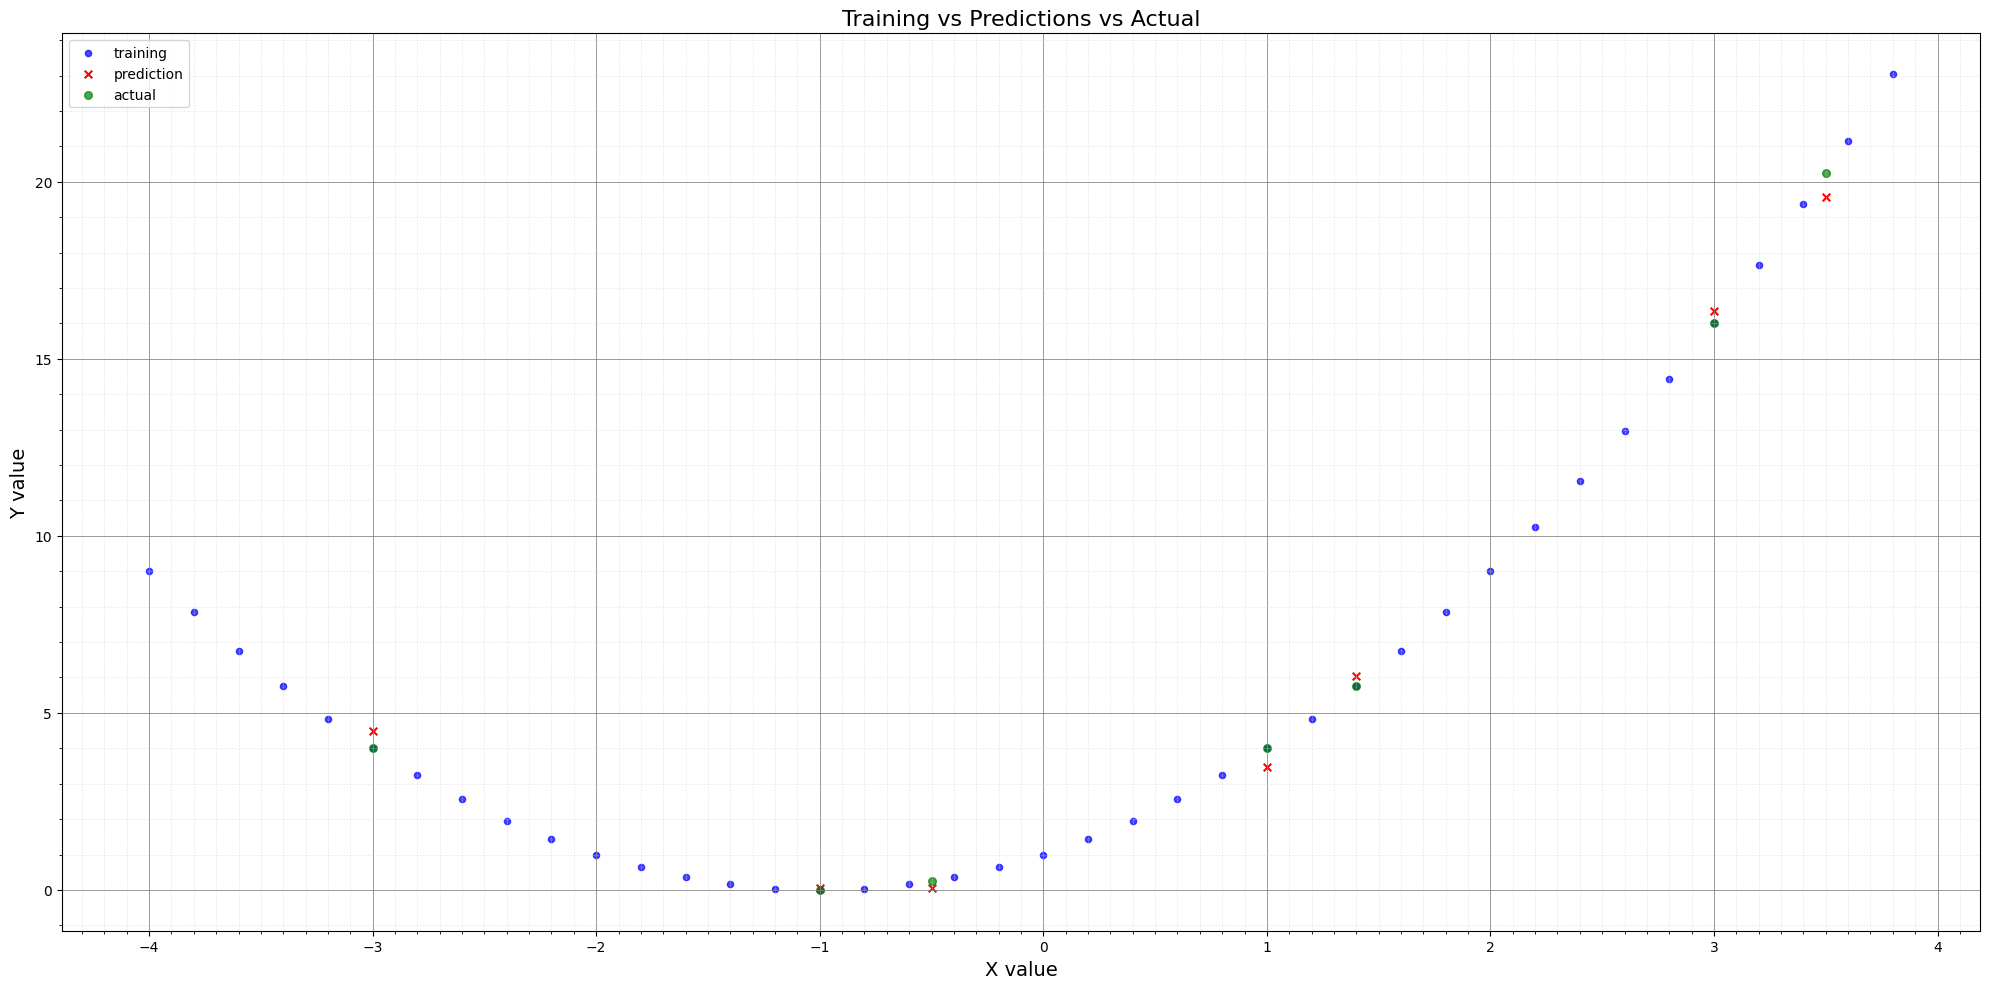

In [11]:
def predict(x_test):
    predictions = []
    for x in x_test:
        x_in = x[0]
        y_pred = mlp([Value(x_in)]).data
        predictions.append(y_pred)

    return predictions


def evaluate(x_test, y_test):
    import math

    y_preds = predict(x_test)
    y_total = len(y_test)

    absolute_err = [abs(y_pred - y_true) for y_pred, y_true in zip(y_preds, y_test)]
    squared_err = [(y_pred - y_true) ** 2 for y_pred, y_true in zip(y_preds, y_test)]

    mean_absolute_error = sum(absolute_err) / y_total
    mean_squared_error = sum(squared_err) / y_total
    root_mean_squared_error = math.sqrt(mean_squared_error)

    epsilon = 1e-8
    mean_absolute_percentage_error = sum(
        abs(y_pred - y_true) / max(abs(y_true), epsilon)
        for y_pred, y_true in zip(y_preds, y_test)
    ) * (100.0 / y_total)

    y_mean = sum(y_test) / y_total
    ss_tot = sum((y_true - y_mean) ** 2 for y_true in y_test)
    ss_res = sum((y_pred - y_true) ** 2 for y_pred, y_true in zip(y_preds, y_test))
    r2 = 1.0 - (ss_res / ss_tot if ss_tot != 0 else float("nan"))

    per_sample_acc = [
        100.0 * (1.0 - abs(y_pred - y_true) / max(abs(y_true), epsilon))
        for y_pred, y_true in zip(y_preds, y_test)
    ]

    print("-------------------------- Evaluation ------------------------------------")
    print(f"Mean Absolute Error             : {mean_absolute_error:.6f}")
    print(f"Root Mean Squared Error         : {root_mean_squared_error:.6f}")
    print(
        f"Mean Absolute Percentage Error  : {mean_absolute_percentage_error:.4f}%   (higher is better when reported as 100 - MAPE)"
    )
    print(f"R^2                             : {r2:.6f}")

    print("Sample comparisons:")
    for x, y_true, y_pred, accuracy in list(
        zip(x_test, y_test, y_preds, per_sample_acc)
    ):
        print(
            f"x={x[0]:8.3f} | y_true={y_true:12.6f} | y_pred={y_pred:12.6f} | approx={accuracy:7.3f}%"
        )

    return {
        "y_preds": y_preds,
        "MAE": mean_absolute_error,
        "RMSE": root_mean_squared_error,
        "MAPE_percent": mean_absolute_percentage_error,
        "R2": r2,
        "per_sample_accuracy_percent": per_sample_acc,
    }


def plot_predictions(
    x_train, y_train, x_test, y_test, y_preds, title="Training vs Predictions vs Actual"
):
    import matplotlib.pyplot as plt
    from matplotlib.ticker import MultipleLocator

    plt.figure(figsize=(20, 10))

    # Training points
    plt.scatter(
        [x[0] for x in x_train],
        y_train,
        color="blue",
        label="training",
        s=20,
        alpha=0.7,
    )

    # Predicted points
    plt.scatter(
        [x[0] for x in x_test],
        y_preds,
        color="red",
        label="prediction",
        s=30,
        marker="x",
    )

    # Actual points
    plt.scatter(
        [x[0] for x in x_test],
        y_test,
        color="green",
        label="actual",
        s=30,
        alpha=0.7,
    )

    # Axis labels and title
    plt.xlabel("X value", fontsize=14)
    plt.ylabel("Y value", fontsize=14)
    plt.title(title, fontsize=16)

    # Grid: major + minor ticks
    plt.minorticks_on()
    plt.grid(which="major", color="gray", linestyle="-", linewidth=0.7, alpha=0.8)
    plt.grid(which="minor", color="lightgray", linestyle="--", linewidth=0.5, alpha=0.5)

    # Tick spacing (example: 0.5 on X, 5 on Y — adjust to your range)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax.yaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(MultipleLocator(1))

    plt.legend()
    plt.tight_layout()
    plt.show()


results = evaluate(val_X, val_Y)

plot_predictions(
    train_X,
    train_Y,
    val_X,
    val_Y,
    results["y_preds"],
    title="Training vs Predictions vs Actual",
)